In [2]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.global_names import *
from pythetatools.base_visualisation import *
from pythetatools.file_manager import read_histogram, download
from collections import defaultdict


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

In [4]:
%load_ext autoreload
%autoreload 2

In [45]:
param = 'delta'
basename_directory = f"MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_{param}"
dir_ver = 'OA2023'
input_path = f"/sps/t2k/Archive_OA2023_ToKeep/Fit_results/DataFit/{basename_directory}"

patern = '*.root'
destination = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"

In [23]:
download(input_path, destination, new_name='', pattern=patern, login=my_login, domain=my_domain, overwrite=False)

directory
Destination folder already exists: /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_delta
Executing: rsync -ah --progress --include='*.root' --exclude='*' dcarabad@cca.in2p3.fr:/sps/t2k/Archive_OA2023_ToKeep/Fit_results/DataFit/MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_delta/ /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_delta/
receiving file list ... 
21 files to consider
./

sent 41 bytes  received 388 bytes  286.00 bytes/sec
total size is 185.43K  speedup is 432.24


In [46]:
file_pattern = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}/marg*.root"

grid, avnllh, param_name = likelihood.load(file_pattern)
grid, param_name = likelihood.transform_s2213_to_sin213(grid, param_name)
llh = likelihood.Loglikelihood(grid, avnllh, param_name, kind='joint')
param_name_x = param_name[0]
grid_x = grid[0]

Number of entries in 'MargTemplate': 2040.
Grid sizes: [51] for parameters ['delta']
Tranformation will not be done as in your param_name there is not sin2213


0.019912385503783353


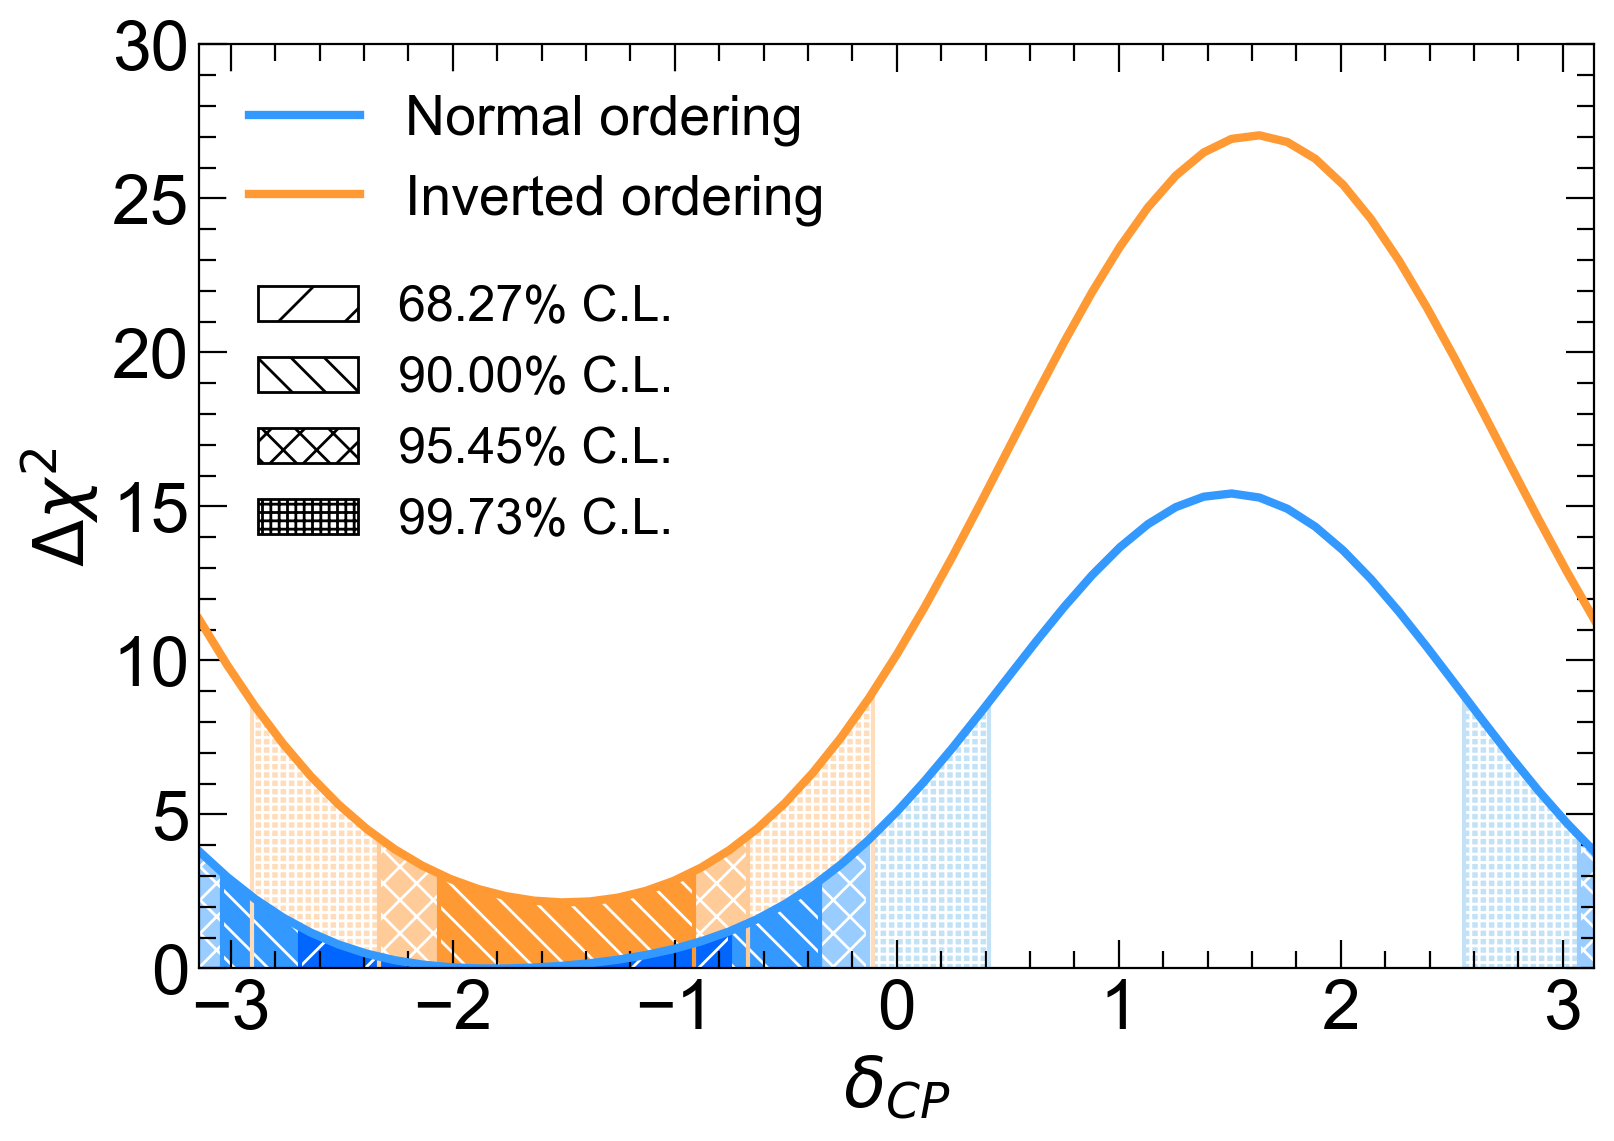

In [48]:
crit_val_central_NO = get_critical_values(param_name_x, true_param_grid_sorted[param_name_x], 0)
crit_val_central_IO = get_critical_values(param_name_x, true_param_grid_sorted[param_name_x], 1)
critical_values=[crit_val_central_NO, crit_val_central_IO]

fig, ax = plt.subplots()
llh.plot(ax, show_const_critical=False, x_critical_values=true_param_grid_sorted[param_name_x], critical_values=[crit_val_central_NO, crit_val_central_IO])

if param_name_x=='sin223': 
    ax.set_xlim(0.38, 0.64)
    ax.set_ylim(0, 25)
elif param_name_x=='delta':
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(0, 30)
    
fig.savefig(f"{outputs_dir}/plots/{dir_ver}/FC/FC_{param_name_x}_main.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{outputs_dir}/plots/{dir_ver}/FC/FC_{param_name_x}_main.svg", bbox_inches='tight', dpi=300)


# Save llh in hists

In [20]:
likelihood.save_avnll_hist(llh, destination)


Objects written in /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_sin223/hist.root
Objects written in /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_sin223/hist_IH.root
Histograms saved to ROOT files.


Warning in <TROOT::Append>: Replacing existing TH1: cont (Potential memory leak).


# Follow next cells for dm2 smearing

In [61]:
def smear_contour(smear_factor=3.3e-5, compile=False):
    if compile:
        macro_path = "../pythetatools/macros/Smear.C"
        !g++ {macro_path} -o ../build/Smear `root-config --cflags --libs`

    for suf in ['', '_IH']:
        input_file = os.path.join(destination, f'hist{suf}.root')
        output_file = os.path.join(destination, f'hist{suf}_smeared_{smear_factor}.root')
        
        !../build/Smear {input_file} {output_file} {smear_factor}


In [91]:

avnllh = {}
smear_factor = 3.3e-5
for mo in [0, 1]:
    bin_xedges, double_avnllh = read_histogram(os.path.join(destination, f'hist{mo_to_suffix[mo]}_smeared_{smear_factor}.root'), 'cont', 1)
    avnllh[mo] = double_avnllh/2
grid_x = (bin_xedges[1:]+bin_xedges[:-1])/2
grid = [grid_x]
llh_smear = likelihood.Loglikelihood(grid, avnllh, param_name, kind='conditional')

fig, ax = plt.subplots()
llh_smear.plot(ax, wtag=True, ls='-')


ax.set_xlim(2.32e-3, 2.7e-3)
ax.set_ylim(0, 12)

# Validation of the margtemplates loading

In [12]:
bin_xedges, double_avnllh = read_histogram(destination+'/hist_Lucile.root', 'cont', 1)

avnllh = {}
grid_x = (bin_xedges[1:]+bin_xedges[:-1])/2
grid = [grid_x]
avnllh[0] = double_avnllh/2

llh_Lucile = likelihood.Loglikelihood(grid, avnllh, param_name, kind='joint')

bin_xedges, double_avnllh = read_histogram(destination+'/hist_smeared_Lucile.root', 'cont', 1)

avnllh = {}
grid_x = (bin_xedges[1:]+bin_xedges[:-1])/2
grid = [grid_x]
avnllh[0] = double_avnllh/2

llh_smeared_Lucile = likelihood.Loglikelihood(grid, avnllh, param_name, kind='joint')

(0.0, 10.0)

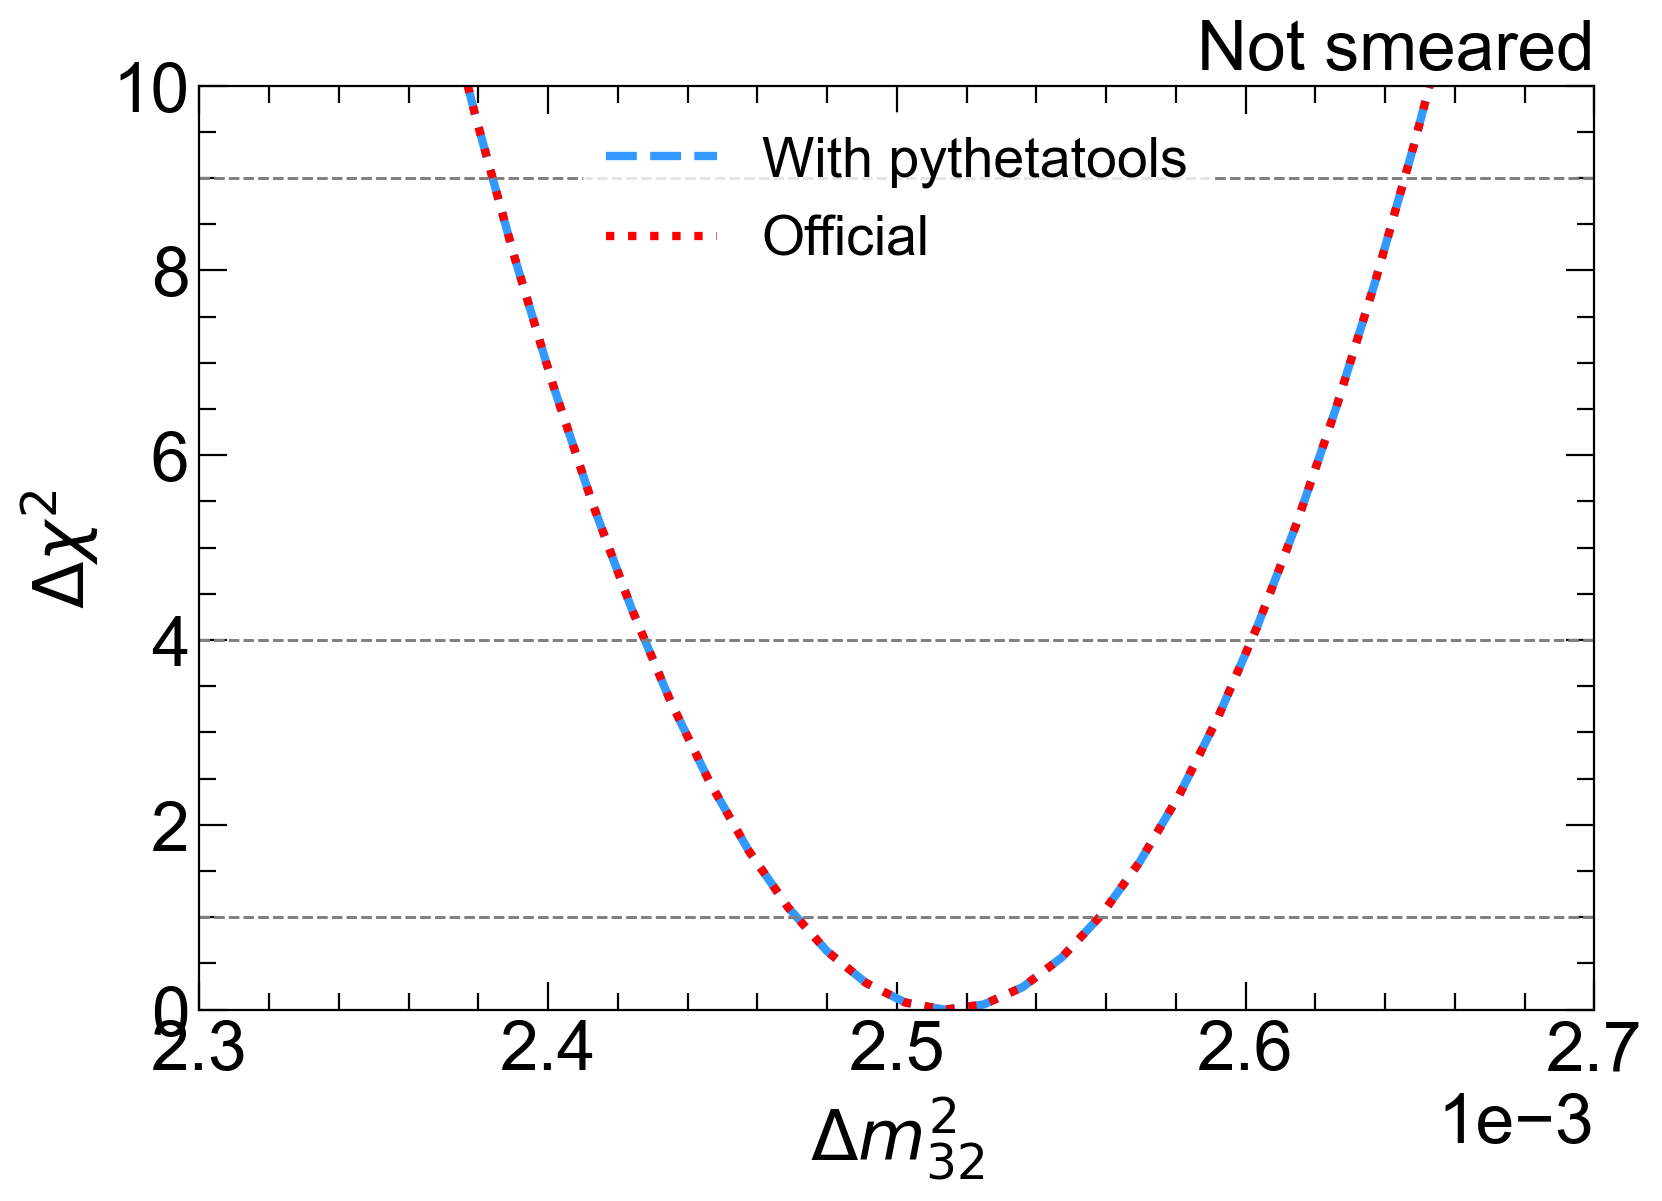

In [13]:
fig, ax = plt.subplots()
llh.plot(ax, mo=0, label='With pythetatools', ls='--')
llh_Lucile.plot(ax, mo=0, color='red', label='Official', ls='dotted')

ax.set_title('Not smeared', loc='right')
ax.set_xlim(2.3e-3, 2.7e-3)
ax.set_ylim(0, 10)

In [17]:
avnllh = {}
smear_factor = 3.5e-5
for mo in [0, 1]:
    bin_xedges, double_avnllh = read_histogram(os.path.join(destination, f'hist{mo_to_suffix[mo]}_smeared_{smear_factor}.root'), 'cont', 1)
    avnllh[mo] = double_avnllh/2
grid_x = (bin_xedges[1:]+bin_xedges[:-1])/2
grid = [grid_x]
llh_smear_3_5 = likelihood.Loglikelihood(grid, avnllh, param_name, kind='joint')

(0.0, 10.0)

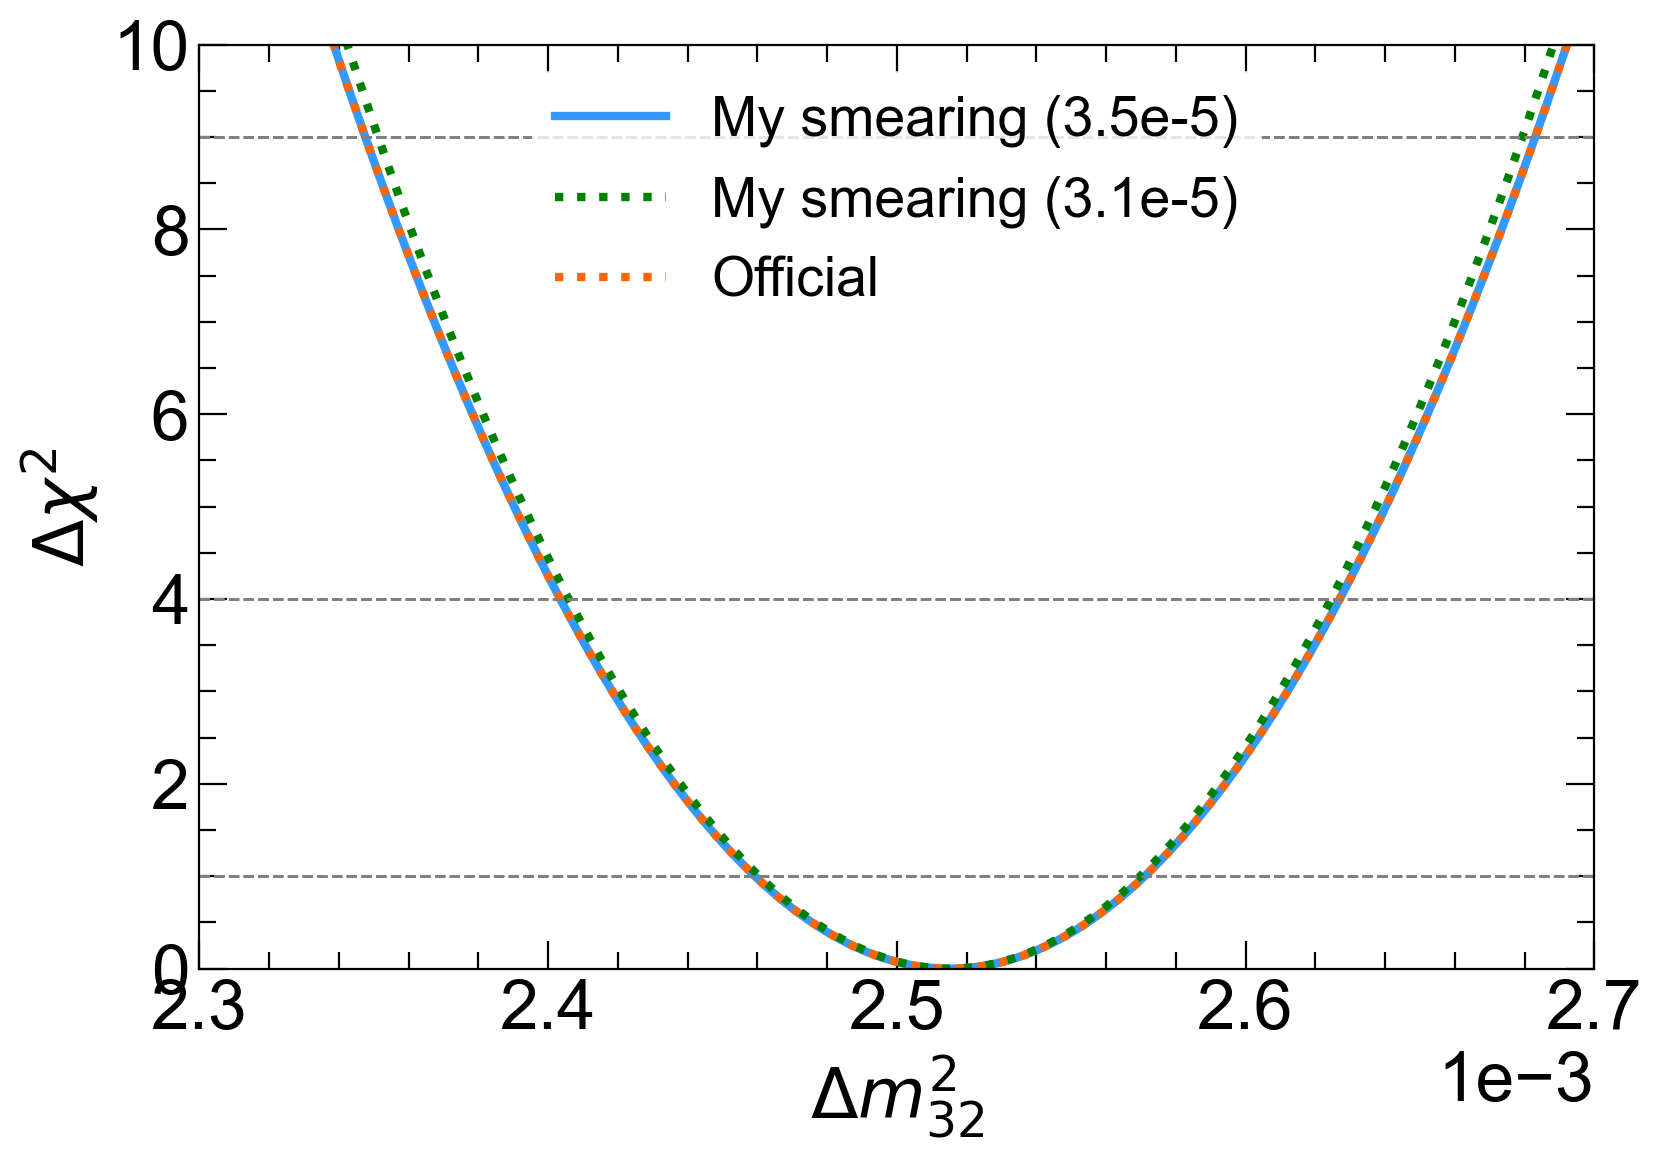

In [26]:
fig, ax = plt.subplots()
llh_smear_3_5.plot(ax, mo=0, color=midblue, label='My smearing (3.5e-5)', ls='-')
llh_smear.plot(ax, mo=0, color='green', label='My smearing (3.1e-5)', ls='dotted')
llh_smeared_Lucile.plot(ax, mo=0, color=darkorange, label='Official', ls='dotted')

ax.set_xlim(2.3e-3, 2.7e-3)
ax.set_ylim(0, 10)